## Week11 Lab

In this lab we will fit SIR and SEIR models to **real** trajectories of incident hospitalizations in the US.


In [2]:
import pandas as pd

influenza_cases = pd.read_csv("https://raw.githubusercontent.com/computationalUncertaintyLab/Flusight-forecast-data/master/data-truth/truth-Incident%20Hospitalizations.csv")

location_pops = pd.read_csv("https://raw.githubusercontent.com/computationalUncertaintyLab/Flusight-forecast-data/master/data-locations/locations.csv")

influenza_data = influenza_cases.merge(location_pops, on = ["location","location_name"])
influenza_data = influenza_data.loc[influenza_data.date>="2022-09-01",: ]

influenza_data

,date,location,location_name,value,abbreviation,population,count_rate1per100k,count_rate2per100k
138,2022-09-03,01,Alabama,21,AL,5039877,50,101
139,2022-09-10,01,Alabama,11,AL,5039877,50,101
140,2022-09-17,01,Alabama,17,AL,5039877,50,101
141,2022-09-24,01,Alabama,20,AL,5039877,50,101
142,2022-10-01,01,Alabama,24,AL,5039877,50,101
...,...,...,...,...,...,...,...,...
8493,2023-02-04,78,Virgin Islands,0,VI,107268,1,2
8494,2023-02-11,78,Virgin Islands,0,VI,107268,1,2
8495,2023-02-18,78,Virgin Islands,0,VI,107268,1,2
8496,2023-02-25,78,Virgin Islands,0,VI,107268,1,2


In [3]:
pa = influenza_data.loc[influenza_data.location=='42']

#--subset to this season
pa_this_season = pa.loc[ pa.date>="2022-09-01",: ]
print(pa)

nrows,ncols = pa_this_season.shape
weeks = np.arange(nrows)

pa_this_season['week'] = weeks

            date location location_name  value abbreviation  population  \
4602  2022-09-03       42  Pennsylvania     40           PA    12964056   
4603  2022-09-10       42  Pennsylvania     35           PA    12964056   
4604  2022-09-17       42  Pennsylvania     29           PA    12964056   
4605  2022-09-24       42  Pennsylvania     35           PA    12964056   
4606  2022-10-01       42  Pennsylvania     53           PA    12964056   
4607  2022-10-08       42  Pennsylvania     59           PA    12964056   
4608  2022-10-15       42  Pennsylvania     76           PA    12964056   
4609  2022-10-22       42  Pennsylvania     97           PA    12964056   
4610  2022-10-29       42  Pennsylvania    179           PA    12964056   
4611  2022-11-05       42  Pennsylvania    238           PA    12964056   
4612  2022-11-12       42  Pennsylvania    366           PA    12964056   
4613  2022-11-19       42  Pennsylvania    438           PA    12964056   
4614  2022-11-26       42

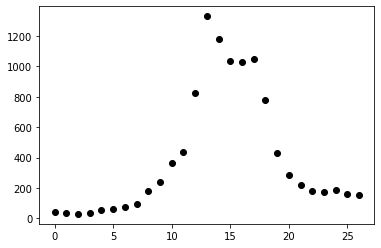

In [4]:
plt.scatter(pa_this_season.week,pa_this_season.value.values, color="k")

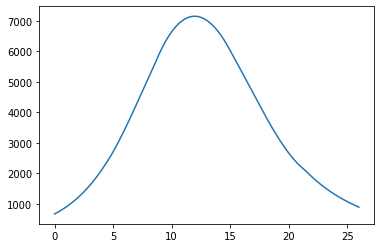

In [5]:
from scipy.integrate import solve_ivp 

def seir(t,y,R0,gamma):
    s,i,r, c = y
    
    beta = R0*gamma
    ds = -beta*s*i
    di = beta*s*i  - gamma*i
    dr = gamma*i
    
    dc = beta*s*i
    
    return [ds,di,dr,dc]

i0 = 0.01
s0 = 1-i0
r0 = 0

min_weeks, max_weeks = min(weeks), max(weeks)

results = solve_ivp(seir
                    , t_span = (min_weeks,max_weeks) 
                    , t_eval = np.arange(min_weeks,max_weeks+0.01,0.01)
                    , y0 = (s0,i0,r0,i0)
                    , args = (2.25, 1./4) )

times_points_for_states = results.t
states_over_time        = results.y

inc_cases = states_over_time[-1,:]
inc_cases = np.diff(inc_cases)

inc_cases = np.append(inc_cases[0], inc_cases)

plt.plot(times_points_for_states, (12*10**6)*inc_cases)

 active_mask: array([0., 0., 0.])
        cost: 35439517824.335724
         fun: array([266231.16956636])
        grad: array([-4.81663683e+11,  5.32265450e+11,  3.69916296e+11])
         jac: array([[-1809193.4296875 ,  1999260.45703125,  1389455.25      ]])
     message: 'The maximum number of function evaluations is exceeded.'
        nfev: 300
        njev: 289
  optimality: 532265449743.20325
      status: 0
     success: False
           x: array([0.5802043 , 0.1319189 , 0.00951382])


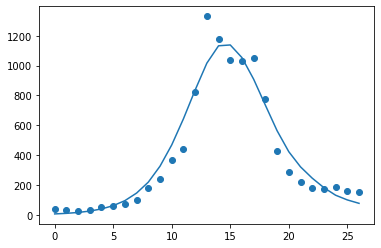

In [196]:
from scipy.optimize import least_squares
def generate_proposed_inc_cases(beta_gamma_phi, N, inital_conditions, start_end):
    import numpy as np 
    from scipy.integrate import solve_ivp
        
    #--SIR differential equations
    def sir(t,y, beta, gamma):
        s,i, r, c = y
        ds_dt = -beta*s*i
        di_dt = beta*s*i - gamma*i
        dr_dt = gamma*i

        dc_dt = beta*s*i #--incident cases
        return [ds_dt, di_dt, dr_dt, dc_dt]
    
    #--lets assume we will always want step sizes of 0.1
    start,end = start_end
    tvals = np.arange(start, end+1+0.1, 0.1)
    
    #--parse arguments from function 
    beta,gamma,phi = beta_gamma_phi

    #--function to return s,i,r over time
    solution = solve_ivp( fun = sir
                         , t_span = (start,end+1)
                         , y0     = initial_conditions
                         , t_eval = tvals
                         , args   = (beta, gamma))

    #--extract from the solution object the times and a matrix of the three states
    times  = solution.t
    states = solution.y
    
    #--compute incident cases
    inc_cases = N*np.diff(states[3,:])*phi
    return inc_cases[::10]

def l2(lambdas, data):
    import numpy as np 
    
    data    = data + np.finfo(float).eps
    lambdas = lambdas + np.finfo(float).eps
    
    #--computelog likelihood
    ll = sum((data-lambdas)**2)
    
    return float(ll) #--return the negative log likelihood

def fit_model(beta_gamma_N       #--this is the argument that minimize will change and maximize 
             ,N
             ,inital_conditions  #--this argument and the one below are needed
             ,start_end
             ,data ):
    proposed_incident_cases = generate_proposed_inc_cases(beta_gamma_N,N, inital_conditions, start_end)
    return l2(proposed_incident_cases, data)

N                  = 12*10**6
initial_conditions = (0.999, 0.001, 0., 0.001)
start_end          = (min_weeks,max_weeks) 
data               = pa_this_season.value.values

results = least_squares(fit_model
         ,x0   = (1./2,1./5,0.01)
         ,args = ( N, initial_conditions, start_end, data )
        )
print(results)

estimated_beta, estimated_gamma, estimated_phi = results.x

estimates = (estimated_beta, estimated_gamma, estimated_phi)
estimated_cases = generate_proposed_inc_cases(estimates, N, initial_conditions, start_end)

plt.scatter(weeks,pa_this_season.value.values)
plt.plot(weeks,estimated_cases)

## Homework Q01

Choose a state from the list of US states that report information on the number of incidetn influenza hospitalizations.

1. Produce a scatter plot of weeks on the horizontal axis and incident hospitalizations on the vertical axis. 
2. Fit a SIR model and fit a SEIR model to the number of incident hospitalizations data. 
3. Plot the estimated incident hospitalizations for the SIR model and SEIR model. 
4. Which model is a better fit? Why?
5. Please describe each step in the above code that is used to fit the SIR model to your data. 

### A nice way to store data as a dataframe. 

There are many different ways to store data as a dataframe in python. 
A dataframe is an object that has two attributes: rows and columns.
Different variables are placed into different columns and observations are considered rows in the dataframe. 

A very convienant way to store a dataframe in python is with a **dictionary**. 
To store a dataframe as a dictionary in python we will assume that the keys of the dictionary are columns which are attached to lists. 

In [8]:
df = {"column1":[], "column2":[], "column3":[]}

Above, i have created a dataframe with three columns and zero rows. 
If i want to add one row to the above dataframe then i need to add one item to each of the lists

In [9]:
df = {"column1":[0], "column2":[34], "column3":[-3]}

To convert my dictionary to a dataframe i can use the **pandas** package

In [10]:
df = pd.DataFrame(df)
df

,column1,column2,column3
0,0,34,-3


Often we want to create several rows of data. 
We do this by adding successive items to each list

In [13]:
df = {"column1":[0,3], "column2":[34,2], "column3":[-3,"a"]}
df = pd.DataFrame(df)
df

,column1,column2,column3
0,0,34,-3
1,3,2,a


We can also access lists that are attached to each key (column) and append values

In [14]:
df = {"column1":[0,3], "column2":[34,2], "column3":[-3,"a"]}

df["column1"].append(2)
df["column2"].append(2.2)
df["column3"].append("hello")

df = pd.DataFrame(df)
df

,column1,column2,column3
0,0,34.0,-3
1,3,2.0,a
2,2,2.2,hello


## Homework Q02

For **each** staate in the list please fit a SIR model. 
We will create a dataframe of statistics from our fitted SIR models. 
Please collected in a dataframe called "stats" the following information:
1. Location name
2. Estimated beta
3. Estimated gamma
4. Estimated phi
5. Compute estimated R0 and store this estimate too

Produce a historgram of R0 values. 

## Homework Q03

Choose the state with the higest R0 value and choose the state with the smallest R0 value. 
1. Produce a scatter plot of weeks on the horizontal axis and incident hospitalizations on the vertical axis for the state with the highest R0.
2. Produce a scatter plot of weeks on the horizontal axis and incident hospitalizations on the vertical axis for the state with the lowest R0.
3. Fit a SIR model to number of incident hospitalizations data for the state with highest R0.
4. Fit a SIR model to number of incident hospitalizations data for the state with lowest R0.
5. Please summarize what you found from this analysis. 

## Homework Q04

Please discuss why the model we chose to fit to our data does makes no sense (think about the states that you are estimating). Is there a way that you could add to the SIR model to produce a model that may make more sense to fit to our data on incident hospitalizations?